# Install libraries

In [87]:
# !pip install cvxopt

# Bitcoin's effect on a classic Portfolio

In [88]:
# Importing Library necessary for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = [14, 6]
np.set_printoptions(formatter={'float': lambda x: f'{x:5.2f}'})
import yfinance as yf
import seaborn as sns

#Import scipy for linear regressions
from scipy import stats
from pypfopt import EfficientFrontier
import cvxpy as cp

import warnings
warnings.filterwarnings("ignore")

## Problem Statement:

### As an investment firm we are facing the question whether an allocation to Bitcoin could improve our fund's performance?

To help answer this question, this report will analyze Bitcoin's performance since 2014, alongside the two other major asset classes in our fund, US equities and gold. In doing so we will answer several questions:

- How does the performance of Bitcoin (i.e. risk and returns) compare to the S&P 500 and the price of gold?
- How does the inclusion of Bitcoin change a portfolio's characteristics and can it help improve a portfolio's performance?
- Could Bitcoin be used as a hedge against inflation? (as claimed by crypto bros)

In the light of our fund's goal to minimize risk: What is the minimum volatility portfolio, consisting of these three asset classes? And for comparison: Which portfolio would maximize risk-adjusted returns?

### Data Collection and Cleaning

In [89]:
start="2014-09-17"
spy_df = yf.download('^GSPC',start)
btc_df = yf.download('BTC-USD',start)
gld_df = yf.download('GC=F',start)
cpi_df = pd.read_excel('CPIAUCSL.xls')    #extracted from the Fred website

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [90]:
spy_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,1999.300049,2010.739990,1993.290039,2001.569946,2001.569946,3209420000
2014-09-18,2003.069946,2012.339966,2003.069946,2011.359985,2011.359985,3235340000
2014-09-19,2012.739990,2019.260010,2006.589966,2010.400024,2010.400024,4880220000
2014-09-22,2009.079956,2009.079956,1991.010010,1994.290039,1994.290039,3349670000
2014-09-23,1992.780029,1995.410034,1982.770020,1982.770020,1982.770020,3279350000


In [91]:
btc_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [92]:
gld_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,1236.199951,1236.199951,1221.900024,1234.400024,1234.400024,10
2014-09-18,1216.199951,1225.699951,1216.199951,1225.699951,1225.699951,5
2014-09-19,1218.300049,1218.300049,1215.300049,1215.300049,1215.300049,4
2014-09-22,1214.900024,1216.800049,1212.400024,1216.800049,1216.800049,7
2014-09-23,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,5


In [93]:
cpi_df.head()

,observation_date,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [94]:
# we can see that the we have one extra day of data compared to BTC data so let's drop that extra day
spy_df = spy_df[1:]
gld_df = gld_df[1:]

In [95]:
#lets set the index to date for CPI data and rename the date column
cpi_df.rename(columns={'observation_date':'Date'},inplace=True)

In [96]:
cpi_df.set_index('Date',inplace=True)
cpi_df

,CPIAUCSL
Date,
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2023-09-01,307.288
2023-10-01,307.531
2023-11-01,308.024


In [97]:
# Lets merge equity data and gold data together
merged_df1 = spy_df.merge(btc_df,on='Date',how='left').merge(gld_df,on='Date',how='left')
merged_df1

,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2014-09-18,2003.069946,2012.339966,2003.069946,2011.359985,2011.359985,3235340000,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,1216.199951,1225.699951,1216.199951,1225.699951,1225.699951,5.0
2014-09-19,2012.739990,2019.260010,2006.589966,2010.400024,2010.400024,4880220000,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,1218.300049,1218.300049,1215.300049,1215.300049,1215.300049,4.0
2014-09-22,2009.079956,2009.079956,1991.010010,1994.290039,1994.290039,3349670000,399.100006,406.915985,397.130005,402.152008,402.152008,24127600,1214.900024,1216.800049,1212.400024,1216.800049,1216.800049,7.0
2014-09-23,1992.780029,1995.410034,1982.770020,1982.770020,1982.770020,3279350000,402.092010,441.557007,396.196991,435.790985,435.790985,45099500,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,5.0
2014-09-24,1983.339966,1999.790039,1978.630005,1998.300049,1998.300049,3313850000,435.751007,436.112000,421.131989,423.204987,423.204987,30627700,1218.599976,1218.599976,1216.800049,1218.599976,1218.599976,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-04,5130.990234,5149.669922,5127.180176,5130.950195,5130.950195,4758440000,63137.003906,68537.031250,62386.519531,68330.414062,68330.414062,70670471105,2083.600098,2119.800049,2080.699951,2117.699951,2117.699951,805.0
2024-03-05,5110.520020,5114.540039,5056.819824,5078.649902,5078.649902,4418410000,68341.054688,69170.625000,59323.910156,63801.199219,63801.199219,102802940877,2114.899902,2133.500000,2111.399902,2133.500000,2133.500000,1287.0
2024-03-06,5108.029785,5127.970215,5092.220215,5104.759766,5104.759766,4559050000,63776.050781,67637.929688,62848.671875,66106.804688,66106.804688,68750229073,2125.500000,2150.300049,2125.500000,2150.300049,2150.300049,443.0


In [98]:
#lets resample the daily frequency to monthly frequency data
mnth_df = merged_df1.resample('MS').last()

#drop last row as it is not complete
mnth_df = mnth_df[:-1]

mnth_df

,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2014-09-01,1978.209961,1985.170044,1968.959961,1972.290039,1972.290039,3951100000,376.088013,390.976990,373.442993,386.944000,386.944000,34707300,1214.800049,1218.199951,1204.000000,1210.500000,1210.500000,680.0
2014-10-01,2001.199951,2018.189941,2001.199951,2018.050049,2018.050049,4292290000,345.009003,348.045013,337.141998,338.321014,338.321014,12545400,1199.599976,1199.699951,1161.400024,1171.099976,1171.099976,260.0
2014-11-01,2074.780029,2075.760010,2065.060059,2067.560059,2067.560059,2504640000,369.373993,382.838013,358.454987,376.446991,376.446991,22946500,1197.000000,1198.199951,1163.800049,1175.199951,1175.199951,11175.0
2014-12-01,2082.110107,2085.580078,2057.939941,2058.899902,2058.899902,2606070000,310.914001,320.192993,310.210999,320.192993,320.192993,13942900,1199.199951,1199.199951,1182.699951,1183.900024,1183.900024,92.0
2015-01-01,2019.349976,2023.319946,1993.380005,1994.989990,1994.989990,4568650000,232.772003,242.850998,225.839005,226.425003,226.425003,26605200,1258.000000,1284.300049,1257.000000,1278.500000,1278.500000,8626.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,4171.330078,4195.549805,4153.120117,4193.799805,4193.799805,4249470000,34500.078125,34719.253906,34083.308594,34667.781250,34667.781250,15758270810,1996.500000,2001.000000,1983.699951,1985.199951,1985.199951,84.0
2023-11-01,4554.870117,4569.890137,4537.240234,4567.799805,4567.799805,5399300000,37861.117188,38141.753906,37531.140625,37712.746094,37712.746094,18115982627,2046.099976,2047.099976,2033.099976,2038.099976,2038.099976,2506.0
2023-12-01,4782.879883,4788.430176,4751.990234,4769.830078,4769.830078,3126060000,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055,2068.000000,2068.899902,2062.100098,2062.399902,2062.399902,47.0


In [99]:
#lets merge the cpi data with the above merged dataframe
final_df = mnth_df.merge(cpi_df,on='Date')
final_df

,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,Open,High,Low,Close,Adj Close,Volume,CPIAUCSL
Date,,,,,,,,,,,,,,,,,,,
2014-09-01,1978.209961,1985.170044,1968.959961,1972.290039,1972.290039,3951100000,376.088013,390.976990,373.442993,386.944000,386.944000,34707300,1214.800049,1218.199951,1204.000000,1210.500000,1210.500000,680.0,237.477
2014-10-01,2001.199951,2018.189941,2001.199951,2018.050049,2018.050049,4292290000,345.009003,348.045013,337.141998,338.321014,338.321014,12545400,1199.599976,1199.699951,1161.400024,1171.099976,1171.099976,260.0,237.430
2014-11-01,2074.780029,2075.760010,2065.060059,2067.560059,2067.560059,2504640000,369.373993,382.838013,358.454987,376.446991,376.446991,22946500,1197.000000,1198.199951,1163.800049,1175.199951,1175.199951,11175.0,236.983
2014-12-01,2082.110107,2085.580078,2057.939941,2058.899902,2058.899902,2606070000,310.914001,320.192993,310.210999,320.192993,320.192993,13942900,1199.199951,1199.199951,1182.699951,1183.900024,1183.900024,92.0,236.252
2015-01-01,2019.349976,2023.319946,1993.380005,1994.989990,1994.989990,4568650000,232.772003,242.850998,225.839005,226.425003,226.425003,26605200,1258.000000,1284.300049,1257.000000,1278.500000,1278.500000,8626.0,234.747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,4328.180176,4333.149902,4274.859863,4288.049805,4288.049805,3865960000,27024.841797,27225.937500,26721.763672,26911.720703,26911.720703,10396435377,1864.300049,1872.300049,1846.000000,1848.099976,1848.099976,1605.0,307.288
2023-10-01,4171.330078,4195.549805,4153.120117,4193.799805,4193.799805,4249470000,34500.078125,34719.253906,34083.308594,34667.781250,34667.781250,15758270810,1996.500000,2001.000000,1983.699951,1985.199951,1985.199951,84.0,307.531
2023-11-01,4554.870117,4569.890137,4537.240234,4567.799805,4567.799805,5399300000,37861.117188,38141.753906,37531.140625,37712.746094,37712.746094,18115982627,2046.099976,2047.099976,2033.099976,2038.099976,2038.099976,2506.0,308.024


In [100]:
#Lets drop all the columns that are not  adjusted closing price
final_df.drop(['Open_x','High_x','Close_x','Volume_x','Open_y','High_y','Close_y','Volume_y','Open','High','Close','Volume'],axis=1,inplace=True)
final_df.drop(['Low_x','Low_y','Low'],axis=1,inplace=True)
final_df

,Adj Close_x,Adj Close_y,Adj Close,CPIAUCSL
Date,,,,
2014-09-01,1972.290039,386.944000,1210.500000,237.477
2014-10-01,2018.050049,338.321014,1171.099976,237.430
2014-11-01,2067.560059,376.446991,1175.199951,236.983
2014-12-01,2058.899902,320.192993,1183.900024,236.252
2015-01-01,1994.989990,226.425003,1278.500000,234.747
...,...,...,...,...
2023-09-01,4288.049805,26911.720703,1848.099976,307.288
2023-10-01,4193.799805,34667.781250,1985.199951,307.531
2023-11-01,4567.799805,37712.746094,2038.099976,308.024


In [101]:
final_df.rename(columns={'Adj Close_x':'Adj Close_spy','Adj Close_y':'Adj Close_btc','Adj Close':'Adj Close_gld','CPIAUCSL':'CPI'},inplace=True)
final_df

,Adj Close_spy,Adj Close_btc,Adj Close_gld,CPI
Date,,,,
2014-09-01,1972.290039,386.944000,1210.500000,237.477
2014-10-01,2018.050049,338.321014,1171.099976,237.430
2014-11-01,2067.560059,376.446991,1175.199951,236.983
2014-12-01,2058.899902,320.192993,1183.900024,236.252
2015-01-01,1994.989990,226.425003,1278.500000,234.747
...,...,...,...,...
2023-09-01,4288.049805,26911.720703,1848.099976,307.288
2023-10-01,4193.799805,34667.781250,1985.199951,307.531
2023-11-01,4567.799805,37712.746094,2038.099976,308.024


### Exploratary Data Analysis

In [102]:
#Calculate Standardised Returns 
final_df['spy_std_ret'] = final_df['Adj Close_spy']/final_df['Adj Close_spy'][0] *100
final_df['btc_std_ret'] = final_df['Adj Close_btc']/final_df['Adj Close_btc'][0] *100
final_df['gld_std_ret'] = final_df['Adj Close_gld']/final_df['Adj Close_gld'][0] *100
final_df['CPI_pct_change'] = final_df['CPI']/final_df['CPI'][0] *100
final_df

,Adj Close_spy,Adj Close_btc,Adj Close_gld,CPI,spy_std_ret,btc_std_ret,gld_std_ret,CPI_pct_change
Date,,,,,,,,
2014-09-01,1972.290039,386.944000,1210.500000,237.477,100.000000,100.000000,100.000000,100.000000
2014-10-01,2018.050049,338.321014,1171.099976,237.430,102.320146,87.434103,96.745145,99.980209
2014-11-01,2067.560059,376.446991,1175.199951,236.983,104.830426,97.287202,97.083846,99.791980
2014-12-01,2058.899902,320.192993,1183.900024,236.252,104.391335,82.749182,97.802563,99.484161
2015-01-01,1994.989990,226.425003,1278.500000,234.747,101.150944,58.516220,105.617513,98.850415
...,...,...,...,...,...,...,...,...
2023-09-01,4288.049805,26911.720703,1848.099976,307.288,217.414768,6954.939393,152.672447,129.396952
2023-10-01,4193.799805,34667.781250,1985.199951,307.531,212.636059,8959.379452,163.998344,129.499278
2023-11-01,4567.799805,37712.746094,2038.099976,308.024,231.598787,9746.305943,168.368441,129.706877


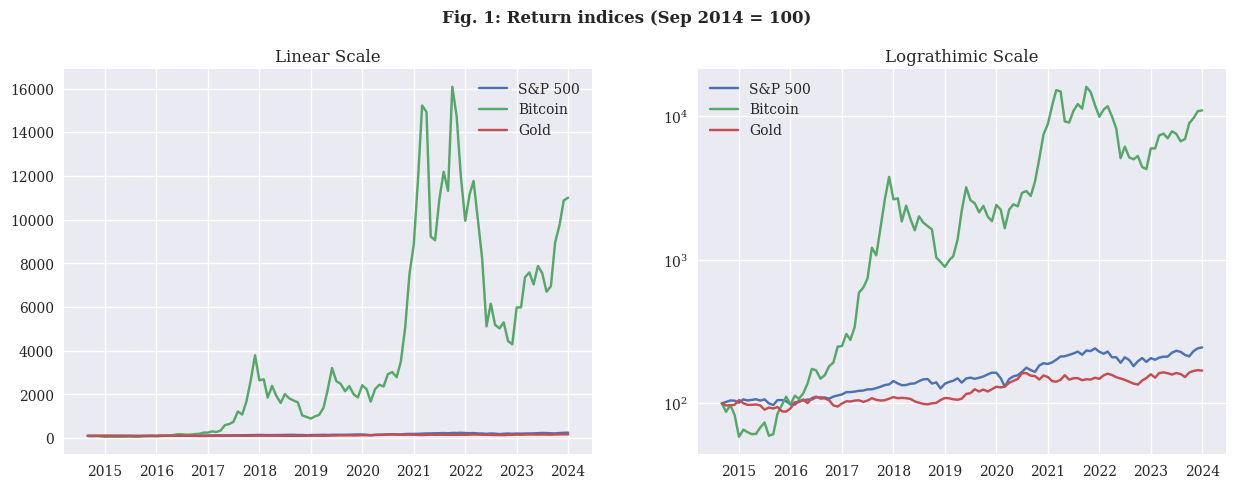

In [103]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plt.suptitle('Fig. 1: Return indices (Sep 2014 = 100)',fontweight='bold',y=1.0)
ax[0].plot(final_df['spy_std_ret'])
ax[0].plot(final_df['btc_std_ret'])
ax[0].plot(final_df['gld_std_ret'])
ax[0].set_title('Linear Scale')
ax[0].legend(['S&P 500','Bitcoin','Gold'])

ax[1].plot(final_df['spy_std_ret'])
ax[1].plot(final_df['btc_std_ret'])
ax[1].plot(final_df['gld_std_ret'])
plt.yscale('log')
ax[1].set_title('Lograthimic Scale')
ax[1].legend(['S&P 500','Bitcoin','Gold'])

In [104]:
##Calculate period performance & annualized performance
spy_return = (final_df['Adj Close_spy'][-1]/final_df['Adj Close_spy'][0])-1
spy_return_ann = (spy_return + 1) ** (1 / (len(final_df) / 12)) - 1

btc_return = (final_df['Adj Close_btc'][-1]/final_df['Adj Close_btc'][0])-1
btc_return_ann = (btc_return + 1) ** (1 / (len(final_df) / 12)) - 1

gld_return = (final_df['Adj Close_gld'][-1]/final_df['Adj Close_gld'][0])-1
gld_return_ann = (gld_return + 1) ** (1 / (len(final_df) / 12)) - 1

print("SP500 ROI : ", spy_return, "SP500 annualized returns : ", spy_return_ann)
print("Bitcoin ROI : ", btc_return, "Bitcoin annualized returns : ", btc_return_ann)
print("Gold ROI : ", gld_return, "Gold annualized returns : ", gld_return_ann)

SP500 ROI :  1.4568647644983597 SP500 annualized returns :  0.10016143242065567
Bitcoin ROI :  109.04849653149472 Bitcoin annualized returns :  0.6474240152432416
Gold ROI :  0.6921932278758778 Gold annualized returns :  0.05745080453551865


We can see that in the time period between 2014 to 2023 bitcoin (64.7% p.a.) outperformed both the S&P500 (10.0% p.a.) and Gold (5.7% p.a.) significantly. 

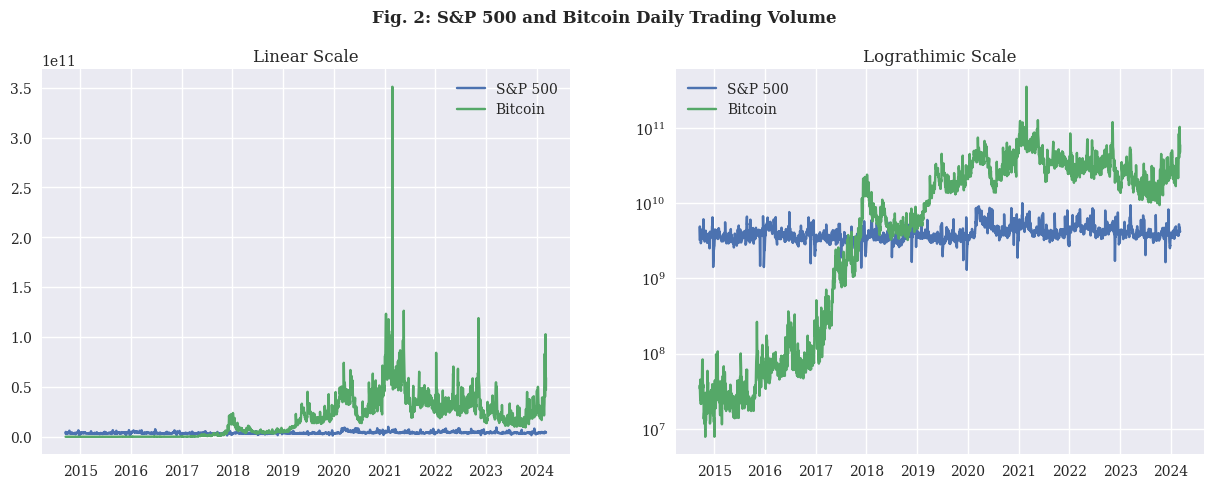

In [105]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plt.suptitle('Fig. 2: S&P 500 and Bitcoin Daily Trading Volume',fontweight='bold',y=1.0)
ax[0].plot(merged_df1['Volume_x'])
ax[0].plot(merged_df1['Volume_y'])
ax[0].set_title('Linear Scale')
ax[0].legend(['S&P 500','Bitcoin'])

ax[1].plot(merged_df1['Volume_x'])
ax[1].plot(merged_df1['Volume_y'])
plt.yscale('log')
ax[1].set_title('Lograthimic Scale')
ax[1].legend(['S&P 500','Bitcoin'])

Figure 2 highlights the rising popularity of Bitcoin based on its trading volume. While trading volume of S&P 500 stocks has been relatively stable throughout the period, it has risen sharply for Bitcoin. Until late-2017 daily S&P 500 trading volumes exceeded Bitcoin's. Since then the trading volume in Bitcoin has been larger than S&P 500's, and by a wide margin.

### Comparing risk and returns of all the asset class in our universe:

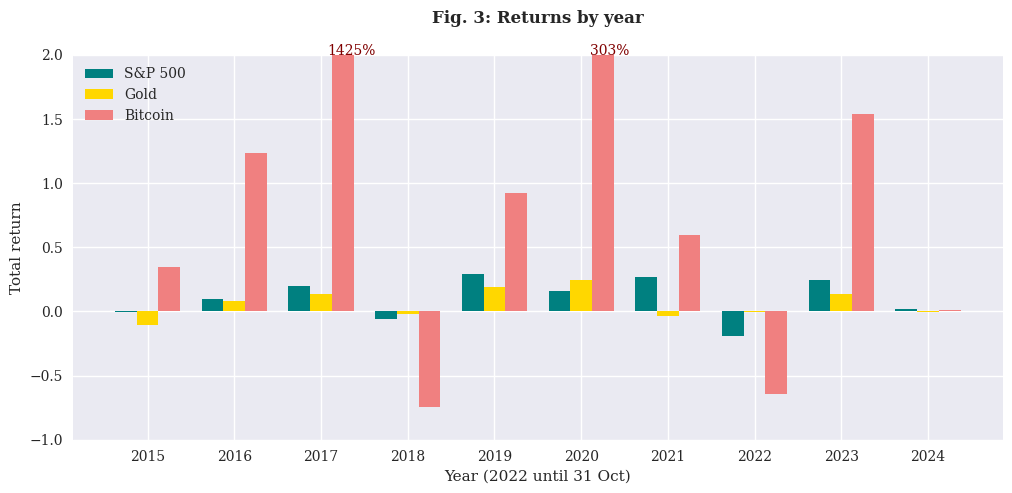

In [106]:
# resample data to annual frequency

ann_df = final_df.resample('Y').last()
ann_df['spy_pct'] = ann_df['Adj Close_spy'].pct_change()
ann_df['btc_pct'] = ann_df['Adj Close_btc'].pct_change()
ann_df['gld_pct'] = ann_df['Adj Close_gld'].pct_change()
ann_df = ann_df[1:]

fig, ax = plt.subplots(figsize=(12,5))
plt.title('Fig. 3: Returns by year', pad=23, fontweight='bold')

years = ann_df.index.year
x_axis = np.arange(len(years))

ax.bar(x_axis, ann_df['spy_pct'], width=0.25, label = 'S&P 500', color='teal')
ax.bar(x_axis + 0.25, ann_df['gld_pct'], width=0.25, label = 'Gold', color='gold')
ax.bar(x_axis + 0.5, ann_df['btc_pct'], width=0.25, label = 'Bitcoin', color='lightcoral')

plt.xticks(x_axis + 0.25, years)
plt.ylim([-1,2])
#ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
#ax.grid(axis='y')
ax.legend(loc='upper left')
ax.set_ylabel('Total return')
ax.set_xlabel('Year (2022 until 31 Oct)')
ax.annotate('1425%', (2.32, 2), color='maroon')
ax.annotate('303%', (5.35, 2), color='maroon')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(left=False)

plt.show()

As can be seen in figure 3 Bitcoin outperformed in each single year except for 2018, and did so by a wide margin. Bitcoin's performance was particularly strong in 2017 (+1425%) and 2020 (+303%).

In [107]:
#Visualizing Monthly Returns of different asset class
final_df['spy_pct']= final_df['Adj Close_spy'].pct_change()
final_df['btc_pct']=final_df['Adj Close_btc'].pct_change()
final_df['gld_pct']=final_df['Adj Close_gld'].pct_change()
final_df=final_df[1:]

final_df


,Adj Close_spy,Adj Close_btc,Adj Close_gld,CPI,spy_std_ret,btc_std_ret,gld_std_ret,CPI_pct_change,spy_pct,btc_pct,gld_pct
Date,,,,,,,,,,,
2014-10-01,2018.050049,338.321014,1171.099976,237.430,102.320146,87.434103,96.745145,99.980209,0.023201,-0.125659,-0.032549
2014-11-01,2067.560059,376.446991,1175.199951,236.983,104.830426,97.287202,97.083846,99.791980,0.024534,0.112692,0.003501
2014-12-01,2058.899902,320.192993,1183.900024,236.252,104.391335,82.749182,97.802563,99.484161,-0.004189,-0.149434,0.007403
2015-01-01,1994.989990,226.425003,1278.500000,234.747,101.150944,58.516220,105.617513,98.850415,-0.031041,-0.292848,0.079905
2015-02-01,2104.500000,253.828003,1212.599976,235.342,106.703373,65.598123,100.173480,99.100966,0.054893,0.121025,-0.051545
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,4288.049805,26911.720703,1848.099976,307.288,217.414768,6954.939393,152.672447,129.396952,-0.048719,0.037801,-0.046486
2023-10-01,4193.799805,34667.781250,1985.199951,307.531,212.636059,8959.379452,163.998344,129.499278,-0.021980,0.288204,0.074184
2023-11-01,4567.799805,37712.746094,2038.099976,308.024,231.598787,9746.305943,168.368441,129.706877,0.089179,0.087833,0.026647


<Axes: xlabel='spy_pct', ylabel='Count'>

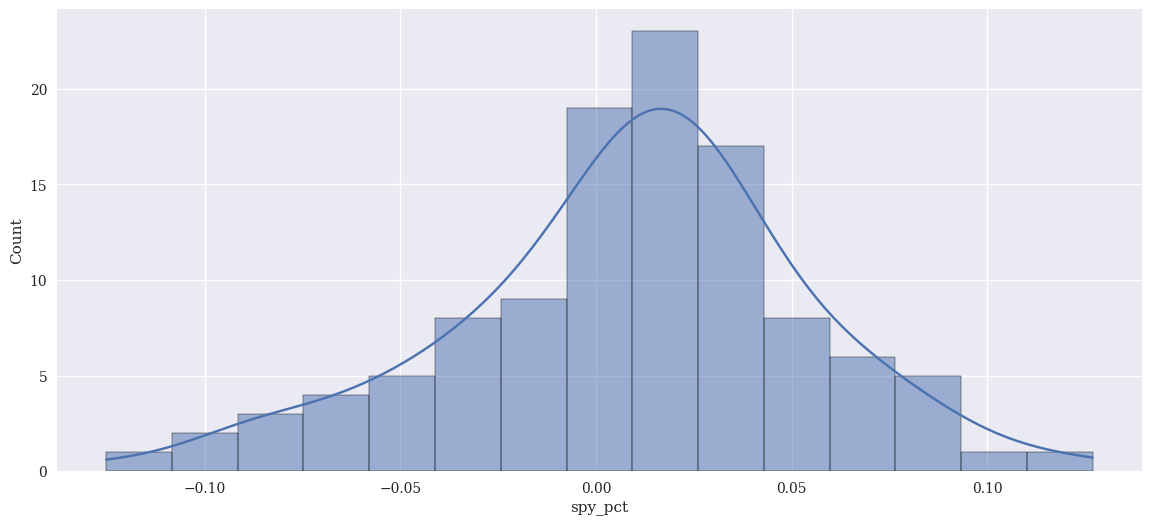

In [108]:
sns.histplot(final_df['spy_pct'],kde=True, bins=15)

<Axes: xlabel='btc_pct', ylabel='Count'>

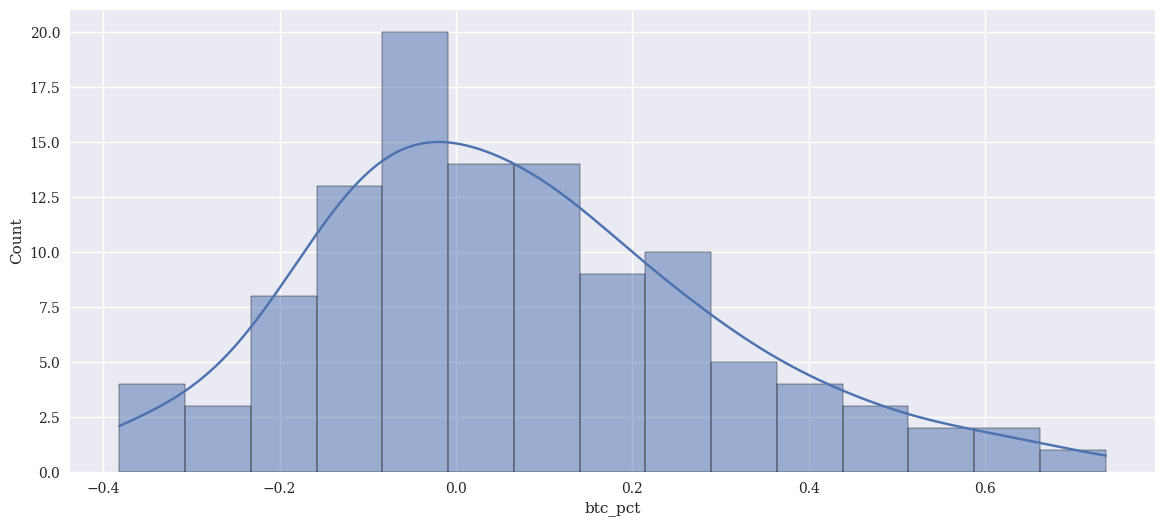

In [109]:
sns.histplot(final_df['btc_pct'],kde=True, bins=15)

<Axes: xlabel='gld_pct', ylabel='Count'>

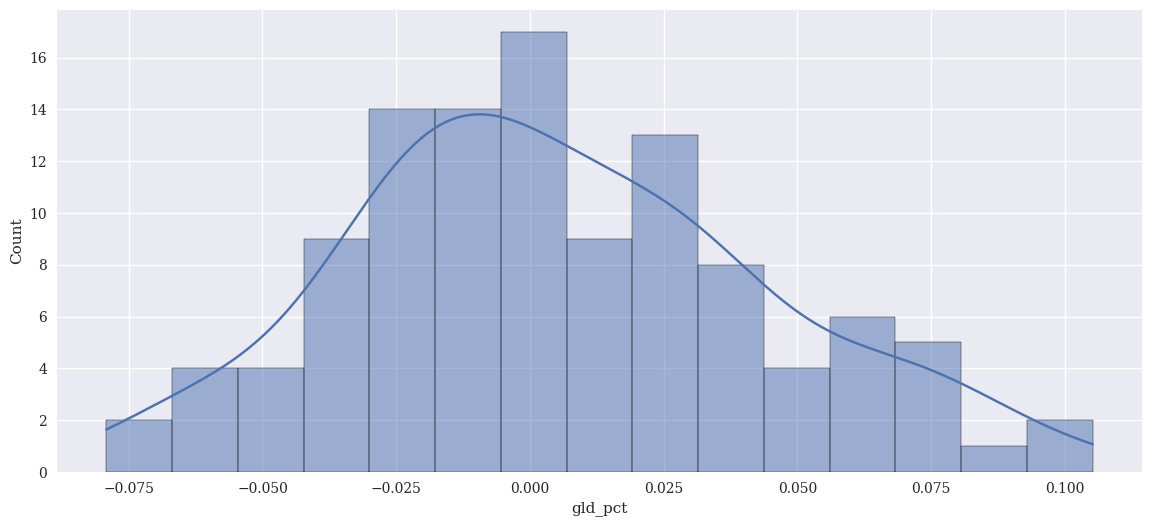

In [110]:
sns.histplot(final_df['gld_pct'],kde=True, bins=15)

Above plots shows that the range of monthly returns is much larger for Bitcoin than for US equities. The returns distribution of BTC is negatively skewed with fat tails same for Gold whereas equities exhibit a classic normal distribution with a slightly positive skeweness.

In [111]:
#Calculating Standard Deviation and Sharpe Ratio

spy_ann_sdv = final_df['spy_pct'].std()*(12**0.5)
btc_ann_sdv = final_df['btc_pct'].std()*(12**0.5)
gld_ann_sdv = final_df['gld_pct'].std()*(12**0.5)

spy_sharpe = spy_return_ann/spy_ann_sdv
btc_sharpe = btc_return_ann/btc_ann_sdv
gld_sharpe = gld_return_ann/gld_ann_sdv

#Max Drawdown
spy_maxDD = min(final_df['Adj Close_spy']/final_df['Adj Close_spy'].expanding().max()-1)
btc_maxDD = min(final_df['Adj Close_btc']/final_df['Adj Close_btc'].expanding().max()-1)
gld_maxDD = min(final_df['Adj Close_gld']/final_df['Adj Close_gld'].expanding().max()-1)

spy_maxDD_daily = min(merged_df1['Adj Close_x']/merged_df1['Adj Close_x'].expanding().max()-1)
btc_maxDD_daily = min(merged_df1['Adj Close_y']/merged_df1['Adj Close_y'].expanding().max()-1)
gld_maxDD_daily = min(merged_df1['Adj Close']/merged_df1['Adj Close'].expanding().max()-1)

#Historical VAR(95%) and CVAR(5%)
spy_Var = final_df['spy_pct'].nsmallest(5)[4]
btc_Var = final_df['btc_pct'].nsmallest(5)[4]
gld_Var = final_df['gld_pct'].nsmallest(5)[4]

spy_CVar = final_df['spy_pct'].nsmallest(5).mean()
btc_CVar = final_df['btc_pct'].nsmallest(5).mean()
gld_CVar = final_df['gld_pct'].nsmallest(5).mean()

#Summary Table
table = {'Annual Return (in %)': [round(spy_return_ann*100,2),round(btc_return_ann*100,2),round(gld_return_ann*100,2)],
        'Annual Volitility (in %)':[round(spy_ann_sdv*100,2),round(btc_ann_sdv*100,2),round(gld_ann_sdv*100,2)],
        'Sharpe Ratio':[round(spy_sharpe,2),round(btc_sharpe,2),round(gld_sharpe,2)],
        'Maximum Drawdown(monthly, in %)':[round(spy_maxDD*100,2),round(btc_maxDD*100,2),round(gld_maxDD*100,2)],
        'Maximum Drawdown(daily, in %)':[round(spy_maxDD_daily*100,2),round(btc_maxDD_daily*100,2),round(gld_maxDD_daily*100,2)],
        'Var(95)(in %)':[round(spy_Var*100,2),round(btc_Var*100,2),round(gld_Var*100,2)],
        'CVar(5)(in %)':[round(spy_CVar*100,2),round(btc_CVar*100,2),round(gld_CVar*100,2)]}
summary_df = pd.DataFrame(table).transpose()
summary_df.columns = ['S&P 500', 'Bitcoin','Gold']

print('\033[1m' +  'Asset class summary statistics (2014-2022)')
display(summary_df)

Asset class summary statistics (2014-2022)


,S&P 500,Bitcoin,Gold
Annual Return (in %),10.02,64.74,5.75
Annual Volitility (in %),15.52,78.17,13.48
Sharpe Ratio,0.65,0.83,0.43
"Maximum Drawdown(monthly, in %)",-24.77,-76.41,-17.07
"Maximum Drawdown(daily, in %)",-33.92,-83.04,-20.87
Var(95)(in %),-8.41,-30.26,-6.45
CVar(5)(in %),-9.65,-34.74,-6.89


Above Summary table confirms that the significantly higher average return of Bitcoin has come at the expense of significantly higher risks. Annualized volatility (based on monthly data) is a whopping 78.17% compared to 15.52% for US equities. The maximum drawdown realized over the period was -83% compared to -34% for the S&P 500 (based on daily data). Still, on risk-adjusted returns, as measured by the Sharpe ratio, Bitcoin's .8 compares favorably to both US stocks (0.65) and gold (0.43). Note that we are using a risk-free rate of zero throughout this report. 

Acknowledging the shortcomings of volatility as a risk measure (e.g. it captures upside volatility as well, which might actually be desirable), we add the historic Value-at-Risk (VaR) for the 95% confidence interval: Bitcoin's VaR of -30.26% has been more than 3-times that of US equities. Finally, "expected shortfall" measures the mean loss below the VaR and gives another indication of Bitcoin's significant tail risk: -34.7% for Bitcoin vs. -9.65% for US equities. VaR and Conditional VaR have their own drawbacks, such as the implicit assumption of normal distribution and should be used carefully too. But in short, Bitcoin comes with significantly higher risk across all measures we looked at.

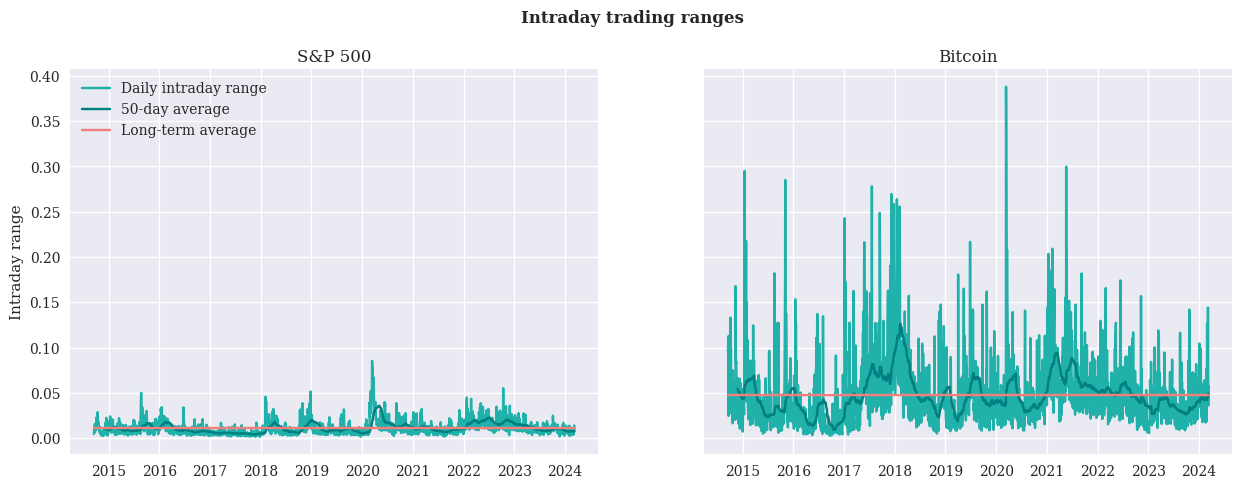

In [112]:
#Add daily intraday trading ranges and plot (SP 500 & BTC only)

merged_df1['spy_range'] = (merged_df1['High_x'] - merged_df1['Low_x'])/merged_df1['Open_x']
merged_df1['btc_range'] = (merged_df1['High_y'] - merged_df1['Low_y'])/merged_df1['Open_y']

merged_df1['spy_range_mean'] = merged_df1['spy_range'].mean()
merged_df1['btc_range_mean'] = merged_df1['btc_range'].mean()

fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
plt.suptitle('Intraday trading ranges',fontweight='bold',y=1.0)

ax[0].plot(merged_df1.index, merged_df1['spy_range'], color='lightseagreen', label='Daily intraday range')
ax[0].plot(merged_df1.index, merged_df1['spy_range'].rolling(50).mean(), color='teal', label='50-day average')
ax[0].plot(merged_df1.index, merged_df1['spy_range_mean'] , color='lightcoral', label='Long-term average')
ax[0].set_title('S&P 500')
ax[0].set_ylabel('Intraday range')
ax[0].legend(loc='upper left')

ax[1].plot(merged_df1.index, merged_df1['btc_range'] , color='lightseagreen')
ax[1].plot(merged_df1.index, merged_df1['btc_range'] .rolling(50).mean(), color='teal')
ax[1].plot(merged_df1.index, merged_df1['btc_range_mean'], color='lightcoral')
ax[1].set_title('Bitcoin')

plt.show()

Another way to highlight Bitcoin's risk is to look at its intraday trading range compared to US equities. The long-term average is 4.9% for Bitcoin vs. 1% for the S&P 500. More interesting are the spikes, which have reached 30-40% for Bitcoin on extreme days - a far cry from what has been observed for equities. Such large intraday swings can potentially cause problems for portfolio (risk) management.

### Bitcoin and Inflation Analysis:

Let's explore how these asset classes are correlated to one another and to inflation and whether Bitcoin has been a good hedge against inflation.

In [113]:
#Calculate correlation matrix on monthly changes
final_df['cpi_pct'] = cpi_df.CPIAUCSL.pct_change()
corr_df = final_df[['spy_pct','btc_pct','gld_pct','cpi_pct']]
corr_df.rename(columns={'spy_pct':'S&P 500','btc_pct':'Bitcoin','gld_pct':'Gold','cpi_pct':'CPI US'},inplace=True)
corr_mat = corr_df.corr().round(2)

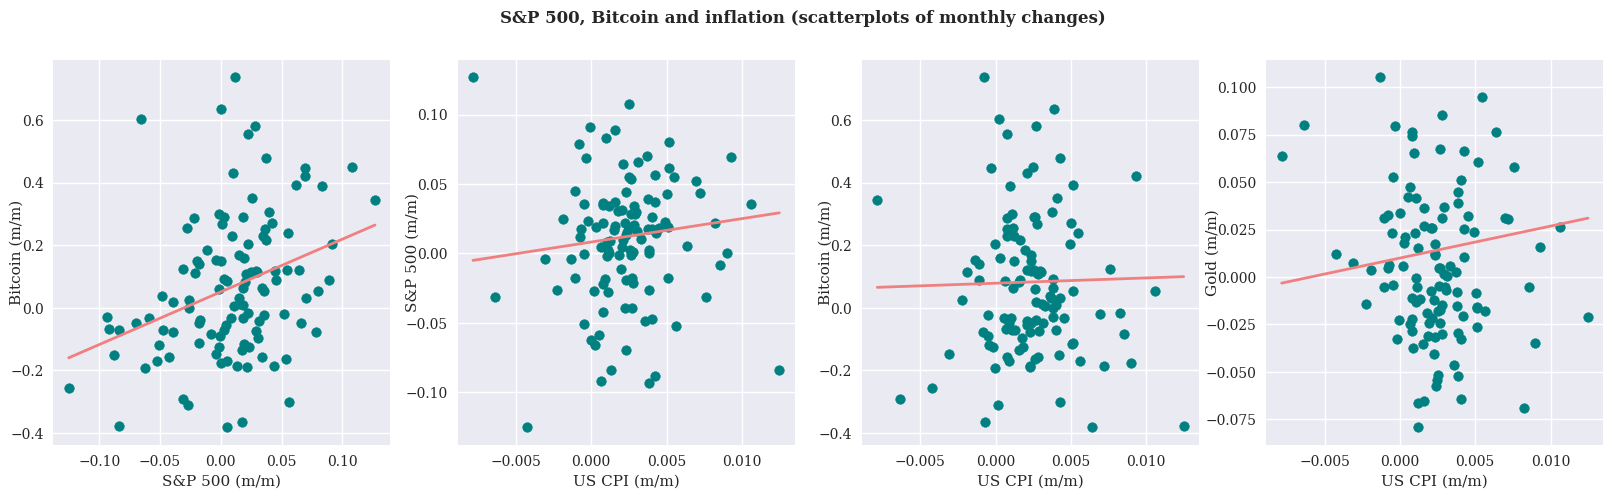


 Correlation coefficients


,S&P 500,Bitcoin,Gold,CPI US
S&P 500,1.00,0.33,0.09,0.02
Bitcoin,0.33,1.00,0.12,-0.07
Gold,0.09,0.12,1.00,-0.15
CPI US,0.02,-0.07,-0.15,1.00


In [114]:
#Scatterplots with linear regression lines
sp = corr_df['S&P 500']
btc = corr_df['Bitcoin']
cpi = corr_df['CPI US']
gld = corr_df['Gold']

res1 = stats.linregress(sp, btc)
res2 = stats.linregress(cpi, sp)
res3 = stats.linregress(cpi, btc)
res4 = stats.linregress(cpi,gld)

fig, ax = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('S&P 500, Bitcoin and inflation (scatterplots of monthly changes)',fontweight='bold')

ax[0].scatter(corr_df['S&P 500'], corr_df['Bitcoin'], color='teal')
ax[0].set_xlabel('S&P 500 (m/m)')
ax[0].set_ylabel('Bitcoin (m/m)',labelpad=-10)
ax[0].tick_params(bottom=False)

fx = np.array([sp.min(), sp.max()])
fy = res1.intercept + res1.slope * fx
ax[0].plot(fx,fy,color='lightcoral',lw=2)

ax[1].scatter(corr_df['CPI US'], corr_df['S&P 500'], color='teal')
ax[1].set_xlabel('US CPI (m/m)')
ax[1].set_ylabel('S&P 500 (m/m)',labelpad=-10)
ax[1].tick_params(bottom=False)

fx = np.array([cpi.min(), cpi.max()])
fy = res2.intercept + res1.slope * fx
ax[1].plot(fx,fy,color='lightcoral',lw=2)

ax[2].scatter(corr_df['CPI US'], corr_df['Bitcoin'], color='teal')
ax[2].set_xlabel('US CPI (m/m)')
ax[2].set_ylabel('Bitcoin (m/m)',labelpad=-10)
ax[2].tick_params(bottom=False)

fx = np.array([cpi.min(), cpi.max()])
fy = res3.intercept + res1.slope * fx
ax[2].plot(fx,fy,color='lightcoral',lw=2)

ax[3].scatter(corr_df['CPI US'], corr_df['Gold'], color='teal')
ax[3].set_xlabel('US CPI (m/m)')
ax[3].set_ylabel('Gold (m/m)',labelpad=-10)
ax[3].tick_params(bottom=False)

fx = np.array([cpi.min(), cpi.max()])
fy = res4.intercept + res1.slope * fx
ax[3].plot(fx,fy,color='lightcoral',lw=2)

plt.show()

print()
print('\033[1m' + ' Correlation coefficients')
display(corr_mat)

The scatterplot of monthly changes as well as the correlation coefficient of close to zero suggest that there has been no consistent relationship between changes in the price of Bitcoin and inflation since 2014. In itself Bitcoin does not offer good hedging properties against inflation, as it has been largely uncorrelated to changes in the general price level. It seems neither positively nor negatively affected by inflation. Gold also exhibits the same relationship as Bitcoin with regards to inflation.

It's also worth noting the positive correlation between the S&P 500 and Bitcoin. A correlation coefficient of 0.3 suggests that Bitcoin tends to move in the same direction as equities, thus offering only limited diversification benefits in a portfolio with equities.

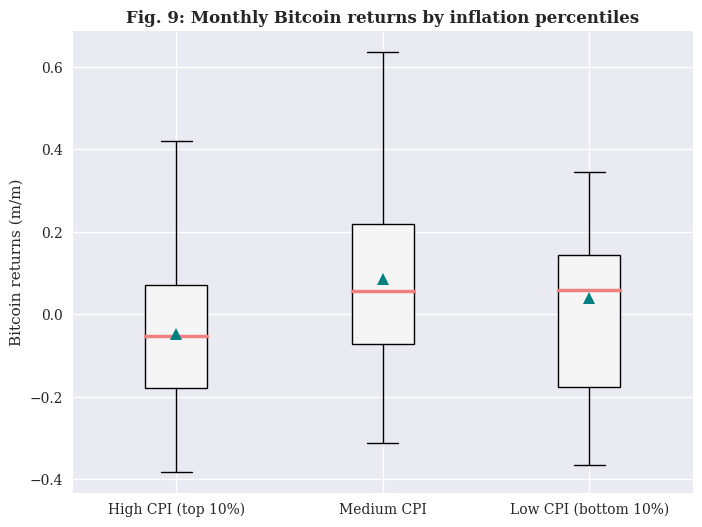

In [115]:
#Find BTC returns in different inflation percentiles and show in boxplot
btc_90perc = corr_df['Bitcoin'][corr_df['CPI US'] >= np.percentile(corr_df['CPI US'],90)]
btc_between = corr_df['Bitcoin'][corr_df['CPI US'] < np.percentile(corr_df['CPI US'],90)][corr_df['CPI US'] > np.percentile(corr_df['CPI US'],10)]
btc_10perc = corr_df['Bitcoin'][corr_df['CPI US'] <= np.percentile(corr_df['CPI US'],10)]

perc_data =  [btc_90perc, btc_between, btc_10perc]

fig, ax = plt.subplots(figsize=(8,6))
plt.title('Fig. 9: Monthly Bitcoin returns by inflation percentiles',fontweight='bold')

ax.boxplot(perc_data,labels=['High CPI (top 10%)','Medium CPI','Low CPI (bottom 10%)'],showfliers=False,showmeans=True,patch_artist=True,
           boxprops=dict(facecolor='whitesmoke'),medianprops=dict(color='lightcoral',linewidth=2.5),meanprops=dict(markerfacecolor='teal',markeredgecolor='teal',markersize=8))

ax.set_ylabel('Bitcoin returns (m/m)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(left=False)

plt.show()

We split the monthly inflation data into its 90th percentile (top 10%), 10th percentile (bottom 10%) and all observations in between (medium) and analyze the behavior of Bitcoin in each of these "buckets" in a boxplot. This plot makes the relatioship more clearer as during high inflation the returns are towards negative territory compared to other 2 periods of inflation. This infacts points that bitcoin mostly produces negative returns during high inflation period as the mean (triangle) and median (line) both are negative.

### Porfolio Allocation and Analysis:

In [116]:
corr_sp500_btc = corr_mat.iloc[0,2]
corr_sp500_gold = corr_mat.iloc[0,1]
corr_btc_gold = corr_mat.iloc[1,2]

vol_list = []
ret_list = []
vol_table = pd.DataFrame()

for i in range(0,120,20):
    for j in range(0,120,20):
        if i+j<=100:
            w_spy = i/100
            w_btc = j/100
            w_gld = 1-w_spy-w_btc
            
            port_vol = ((w_spy**2)*(spy_ann_sdv**2)+(w_btc**2)*(btc_ann_sdv**2)+(w_gld**2)*(gld_ann_sdv**2)
                       +(2*corr_sp500_btc*w_spy*w_btc*spy_ann_sdv*btc_ann_sdv)
                        +(2*corr_sp500_gold*w_spy*w_gld*spy_ann_sdv*gld_ann_sdv)
                       +(2*corr_btc_gold*w_btc*w_gld*btc_ann_sdv*gld_ann_sdv)) ** (1/2)
            
            port_ret = w_spy*spy_return_ann + w_btc*btc_return_ann + w_gld*gld_return_ann
            
            vol_list.append(port_vol*100)
            ret_list.append(port_ret*100)
            
        else:
            vol_list.append(np.nan)
            ret_list.append(np.nan)
            
            
vol_table['0% Equities'] = vol_list[0:6]
vol_table['20% Equities'] = vol_list[6:12]
vol_table['40% Equities'] = vol_list[12:18]
vol_table['60% Equities'] = vol_list[18:24]
vol_table['80% Equities'] = vol_list[24:30]
vol_table['100% Equities'] = vol_list[30:36]

vol_table.set_index(pd.Index(['0% Bitcoin','20% Bitcoin','40% Bitcoin','60% Bitcoin','80% Bitcoin','100% Bitcoin']), inplace=True)

print('\033[1m' + 'Portfolio volatility for different allocations (in % p.a.)')
display(vol_table.style.highlight_min(axis=None, color='cyan'))
        

Portfolio volatility for different allocations (in % p.a.)


,0% Equities,20% Equities,40% Equities,60% Equities,80% Equities,100% Equities
0% Bitcoin,13.483371,12.169180,11.710826,12.205115,13.548175,15.521216
20% Bitcoin,20.030480,19.368644,19.283036,19.781138,20.821101,nan
40% Bitcoin,33.222576,32.943897,33.009515,33.417400,nan,nan
60% Bitcoin,47.847252,47.734232,47.859390,nan,nan,nan
80% Bitcoin,62.913274,62.888107,nan,nan,nan,nan
100% Bitcoin,78.165856,nan,nan,nan,nan,nan


To get an initial idea of how these three asset classes interact in a portfolio, above shows the historical portfolio volatility for different pre-defined combinations of US equities, Bitcoin and gold (the allocation to gold is the residual to make portfolio weights add up to 100%). E.g. a portfolio of 60% US equities, 20% Bitcoin and 20% gold had a volatility of 19.78%. This table already suggests that any allocation to Bitcoin increases portfolio volatility meaningfully. Among these pre-defined portfolios a combination of 40% equities and 60% gold had the lowest volatility (11.7%). Note that this is lower than the volatility of either a pure equity or pure gold portfolio (15.52% respectively 13.48%).

In [117]:
#Add returns to above table to also compare Sharpe ratios
ret_table = pd.DataFrame()

ret_table['0% Equities'] = ret_list[0:6]
ret_table['20% Equities'] = ret_list[6:12]
ret_table['40% Equities'] = ret_list[12:18]
ret_table['60% Equities'] = ret_list[18:24]
ret_table['80% Equities'] = ret_list[24:30]
ret_table['100% Equities'] = ret_list[30:36]

ret_table.set_index(pd.Index(['0% Bitcoin','20% Bitcoin','40% Bitcoin','60% Bitcoin','80% Bitcoin','100% Bitcoin']), inplace=True)

Sharpe_table = ret_table / vol_table

print('\033[1m' + 'Portfolio Sharpe ratio for different allocations')
display(Sharpe_table.style.highlight_max(axis=None, color='orange'))

Portfolio Sharpe ratio for different allocations


,0% Equities,20% Equities,40% Equities,60% Equities,80% Equities,100% Equities
0% Bitcoin,0.426086,0.542296,0.636463,0.680675,0.676248,0.645320
20% Bitcoin,0.875892,0.949925,0.998441,1.016483,1.006738,nan
40% Bitcoin,0.883255,0.916656,0.940712,0.954791,nan,nan
60% Bitcoin,0.859892,0.879823,0.895371,nan,nan,nan
80% Bitcoin,0.841523,0.855442,nan,nan,nan,nan
100% Bitcoin,0.828270,nan,nan,nan,nan,nan


Above table shows the Sharpe ratio (assuming a risk-free rate of zero) for different portfolio allocations. Unlike the minimum volatility portfolio, to optimize the portfolio's risk-adjusted returns in the past would have involved a certain allocation to Bitcoin. The highest risk-adjusted return among these pre-defined allocations would have been achieved with a 60% equity, 20% Bitcoin and 20% gold portfolio (Sharpe ratio of 1.01). We'll next use random sampling to approximate the efficient frontier and both portfolios more precisely.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


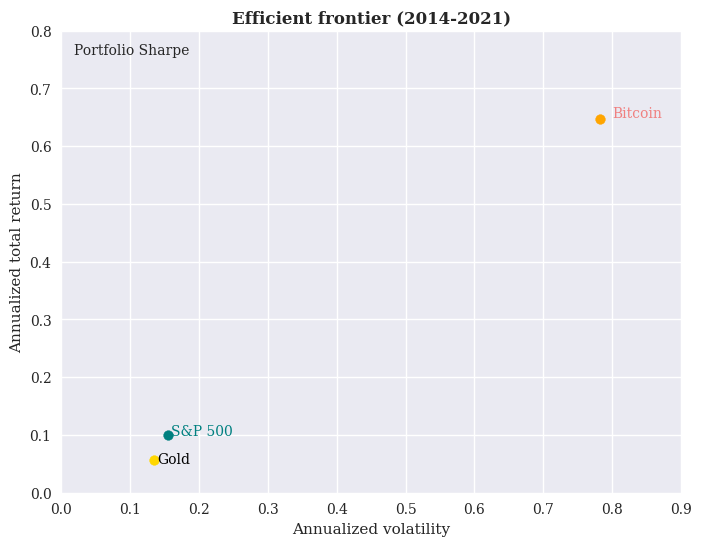

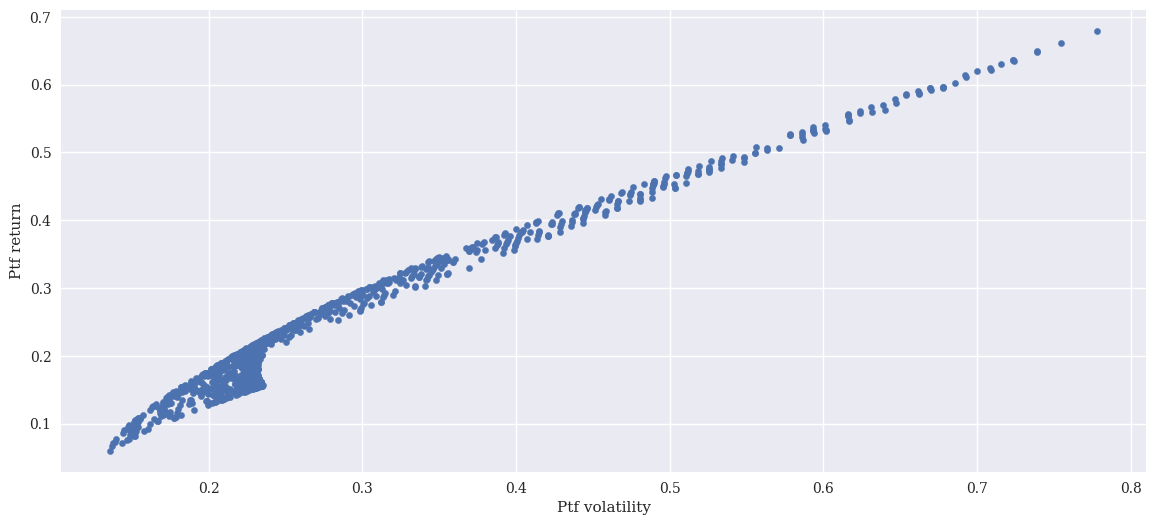

In [118]:
# Run 1000 random portfolio samples to build risk-return scatter (estimated efficient frontier)
risk_ret = {}
risk_w = {}

np.random.seed(1)

for i in np.random.uniform(0,.99,1000):
    w_spy = round(i,4)
    w_btc = np.random.randint(100-w_spy*100)/100
    w_gld = 1-w_spy*w_btc
    
    port_vol = ((w_spy**2)*(spy_ann_sdv**2)+(w_btc**2)*(btc_ann_sdv**2)+(w_gld**2)*(gld_ann_sdv**2)
                       +(2*corr_sp500_btc*w_spy*w_btc*spy_ann_sdv*btc_ann_sdv)
                        +(2*corr_sp500_gold*w_spy*w_gld*spy_ann_sdv*gld_ann_sdv)
                       +(2*corr_btc_gold*w_btc*w_gld*btc_ann_sdv*gld_ann_sdv)) ** (1/2)
            
    port_ret = w_spy*spy_return_ann + w_btc*btc_return_ann + w_gld*gld_return_ann
    
    risk_ret[port_vol]=port_ret
    risk_w[port_vol]=w_spy,w_btc,w_spy
    
risk_return_df = pd.DataFrame(list(risk_ret.items()),columns = ['Ptf volatility','Ptf return']) 
risk_weights_df = pd.DataFrame(list(risk_w.items()),columns = ['Ptf volatility','Asset class weights']) 
risk_return_df['Ptf Sharpe'] = risk_return_df['Ptf return'] / risk_return_df['Ptf volatility']
portfolio_df = risk_return_df.merge(risk_weights_df) 

fig, ax = plt.subplots(figsize=(8,6))
plt.title('Efficient frontier (2014-2021)',fontweight='bold')

portfolio_df.plot.scatter(x = "Ptf volatility",y = "Ptf return")
ax.scatter(spy_ann_sdv, spy_return_ann, color='teal')
ax.scatter(btc_ann_sdv, btc_return_ann, color='orange')
ax.scatter(gld_ann_sdv, gld_return_ann, color='gold')
ax.set_xlabel('Annualized volatility')
ax.set_ylabel('Annualized total return')
ax.set_ylim([0,0.8])
ax.set_xlim([0,0.9])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left',title='Portfolio Sharpe')
ax.annotate('S&P 500', (0.16, 0.10), color='teal')
ax.annotate('Bitcoin', (0.80, 0.65), color='lightcoral')
ax.annotate('Gold', (0.14, 0.05), color='black')

plt.show()

In [119]:
#Approximate the min vola and max Sharpe ratio portfolios (from the 1000 random samples above)
min_vol = portfolio_df['Ptf volatility'].min()
min_vol_ret = portfolio_df['Ptf return'][portfolio_df['Ptf volatility'] == min_vol]
min_vol_SR = portfolio_df['Ptf Sharpe'][portfolio_df['Ptf volatility'] == min_vol]
min_vol_w = portfolio_df['Asset class weights'][portfolio_df['Ptf volatility'] == min_vol]

max_SR = portfolio_df['Ptf Sharpe'].max()
max_SR_vol = portfolio_df['Ptf volatility'][portfolio_df['Ptf Sharpe'] == max_SR]
max_SR_ret = portfolio_df['Ptf return'][portfolio_df['Ptf Sharpe'] == max_SR]
max_SR_w = portfolio_df['Asset class weights'][portfolio_df['Ptf Sharpe'] == max_SR]

#Summary table
Opt_ptfs1 = {'Equity weight (in %)': [round(min_vol_w.reset_index()['Asset class weights'][0][0]*100,0), round(max_SR_w.reset_index()['Asset class weights'][0][0]*100,0)], 
            'Gold weight (in %)': [round(min_vol_w.reset_index()['Asset class weights'][0][1]*100,0), round(max_SR_w.reset_index()['Asset class weights'][0][1]*100,0)],
            'Bitcoin weight (in %)': [round(min_vol_w.reset_index()['Asset class weights'][0][2]*100,0), round(max_SR_w.reset_index()['Asset class weights'][0][2]*100,0)],
            'Annual ptf return (in %)': [round(min_vol_ret.iloc[0]*100,2), round(max_SR_ret.iloc[0]*100,2)],
            'Annual ptf volatility (in %)': [round(min_vol*100,2), round(max_SR_vol.iloc[0]*100,2)], 
            'Ptf Sharpe ratio': [round(min_vol_SR.iloc[0],2), round(max_SR,2)] }

Opt_ptfs1_df = pd.DataFrame(Opt_ptfs1).transpose()
Opt_ptfs1_df.columns = ['Min volatility ptf (random sampling)', 'Max Sharpe ptf (random sampling)']

print('\033[1m' + 'Minimum volatility and maximum Sharpe ratio portfolios (approximated by random sampling)')
display(Opt_ptfs1_df)

Minimum volatility and maximum Sharpe ratio portfolios (approximated by random sampling)


,Min volatility ptf (random sampling),Max Sharpe ptf (random sampling)
Equity weight (in %),3.00,68.00
Gold weight (in %),0.00,28.00
Bitcoin weight (in %),3.00,68.00
Annual ptf return (in %),6.01,29.60
Annual ptf volatility (in %),13.62,29.75
Ptf Sharpe ratio,0.44,1.00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


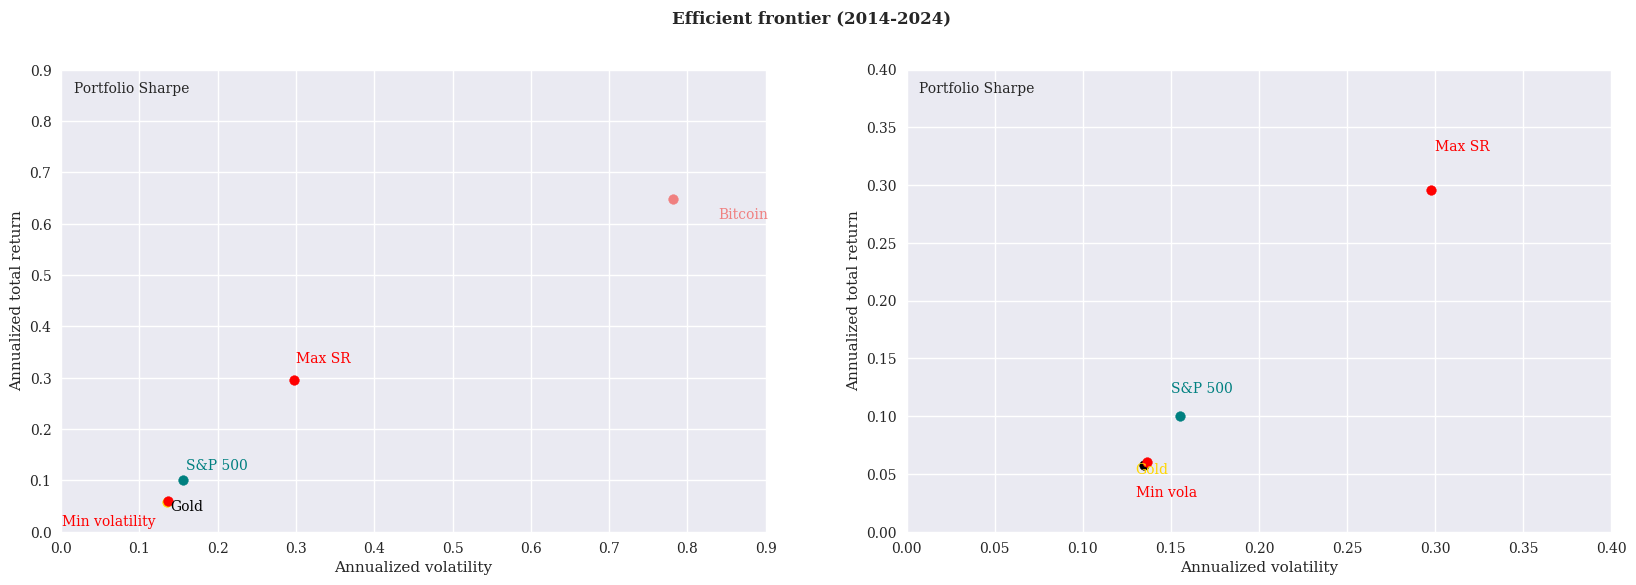

In [120]:
#Add min vola and max Sharpe portfolios to efficinet frontier chart (and "zoom in")
fig, ax = plt.subplots(1,2,figsize=(20,6))
plt.suptitle('Efficient frontier (2014-2024)',fontweight='bold')

# sns.scatterplot(portfolio_df['Ptf volatility'],portfolio_df['Ptf return'],ax=ax[0],hue=portfolio_df['Ptf Sharpe'], palette='RdBu', alpha = 0.5)
ax[0].scatter(spy_ann_sdv, spy_return_ann, color='teal')
ax[0].scatter(btc_ann_sdv, btc_return_ann, color='lightcoral')
ax[0].scatter(gld_ann_sdv, gld_return_ann, color='gold')
ax[0].set_xlabel('Annualized volatility')
ax[0].set_ylabel('Annualized total return')
ax[0].set_ylim([0,0.9])
ax[0].set_xlim([0,0.9])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].legend(loc='upper left',title='Portfolio Sharpe')
ax[0].annotate('S&P 500', (0.16, 0.12), color='teal')
ax[0].annotate('Bitcoin', (0.84, .61), color='lightcoral')
ax[0].annotate('Gold', (0.14, 0.04), color='black')

ax[0].scatter(min_vol, min_vol_ret, color='red')
ax[0].scatter(max_SR_vol, max_SR_ret, color='red')
ax[0].annotate('Min volatility', (0.001, 0.0111), color='red')
ax[0].annotate('Max SR', (0.3, 0.33), color='red')


# sns.scatterplot(portfolio_df['Ptf volatility'],portfolio_df['Ptf return'],ax=ax[1],hue=portfolio_df['Ptf Sharpe'], palette='RdBu', alpha = 0.5)
ax[1].scatter(spy_ann_sdv, spy_return_ann, color='teal')
ax[1].scatter(btc_ann_sdv, btc_return_ann, color='lightcoral')
ax[1].scatter(gld_ann_sdv, gld_return_ann, color='black')
ax[1].set_xlabel('Annualized volatility')
ax[1].set_ylabel('Annualized total return')
ax[1].set_ylim([0,0.4])
ax[1].set_xlim([0,0.4])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].legend(loc='upper left',title='Portfolio Sharpe')
ax[1].annotate('S&P 500', (0.15, 0.12), color='teal')
ax[1].annotate('Gold', (0.13, 0.05), color='gold')

ax[1].scatter(min_vol, min_vol_ret, color='red')
ax[1].scatter(max_SR_vol, max_SR_ret, color='red')
ax[1].annotate('Min vola', (0.13, 0.03), color='red')
ax[1].annotate('Max SR', (0.3, 0.33), color='red')

plt.show()

### Portfolio Optimization:

In [121]:
#Min vola optimization
cov = corr_df.drop('CPI US',axis=1).cov()*12
exp_returns = [spy_return_ann, btc_return_ann, gld_return_ann]

ef = EfficientFrontier(exp_returns, cov, solver=cp.CVXOPT)

ef.min_volatility()
min_vol_w = ef.clean_weights()
min_vol_ptf = ef.portfolio_performance(risk_free_rate=0)

In [122]:
#Max Sharpe optimization
ef = EfficientFrontier(exp_returns, cov)

ef.max_sharpe(risk_free_rate=0)
max_SR_w = ef.clean_weights()
max_SR_ptf = ef.portfolio_performance(risk_free_rate=0)

In [123]:
#Min vola optimization with a min. BTC weight of 5%
ef = EfficientFrontier(exp_returns, cov, weight_bounds=(0.05,1))

ef.min_volatility()
min_volBTC_w = ef.clean_weights()
min_volBTC_ptf = ef.portfolio_performance(risk_free_rate=0)

In [124]:
#Summary table
Opt_ptfs2 = {'Equity weight (in %)': [round(min_vol_w['S&P 500']*100,0), round(max_SR_w['S&P 500']*100,0), round(min_volBTC_w['S&P 500']*100,0)], 
            'Gold weight (in %)': [round(min_vol_w['Gold']*100,0), round(max_SR_w['Gold']*100,0), round(min_volBTC_w['Gold']*100,0)],
            'Bitcoin weight (in %)': [round(min_vol_w['Bitcoin']*100,0), round(max_SR_w['Bitcoin']*100,0), round(min_volBTC_w['Bitcoin']*100,0)],
            'Annual ptf return (in %)': [round(min_vol_ptf[0]*100,2), round(max_SR_ptf[0]*100,2), round(min_volBTC_ptf[0]*100,2)],
            'Annual ptf volatility (in %)': [round(min_vol_ptf[1]*100,2), round(max_SR_ptf[1]*100,2), round(min_volBTC_ptf[1]*100,2)], 
            'Ptf Sharpe ratio': [round(min_vol_ptf[2],2), round(max_SR_ptf[2],2), round(min_volBTC_ptf[2],2)] }

Opt_ptfs2_df = pd.DataFrame(Opt_ptfs2).transpose()
Opt_ptfs2_df.columns = ['Min volatility ptf (opt.)', 'Max Sharpe ptf (opt.)', 'Min Volatility with 5% BTC allocation (opt.)']

print('\033[1m' + ' Minimum volatility and maximum Sharpe ratio portfolios (optimized)')
display(Opt_ptfs2_df)

 Minimum volatility and maximum Sharpe ratio portfolios (optimized)


,Min volatility ptf (opt.),Max Sharpe ptf (opt.),Min Volatility with 5% BTC allocation (opt.)
Equity weight (in %),42.00,45.00,37.00
Gold weight (in %),58.00,40.00,58.00
Bitcoin weight (in %),0.00,15.00,5.00
Annual ptf return (in %),7.55,16.38,10.26
Annual ptf volatility (in %),10.64,16.96,11.84
Ptf Sharpe ratio,0.71,0.97,0.87


The optimal portfolio weights are relatively close to our earlier approximations. Still, optimization further improved the outcome, in particular for the minimum volatility portfolio, which unsurprisingly still contains no allocation to Bitcoin.
In order to acknowledge the superior (risk-adjusted) returns Bitcoin has generated so far, an interesting option could be to allocate a small fixed weight (of say 5%) to Bitcoin and minimize portfolio volatility with this additional constraint. The result is shown in the right column of the above table. The small Bitcoin allocation increases risk, return and Sharpe ratio compared to the strict minimum volatility portfolio. But the increase in volatility (from 10.64% to 11.84%) is relatively small. So, this small allocation to Bitcoin would have improved the fund's performance significantly, without changing its risk profile meaningfully. It would offer the additional advantage of gaining more hands-on experience with investing in Bitcoin, before potentially re-assessing again.

###  Illustration of optimal portfolios:

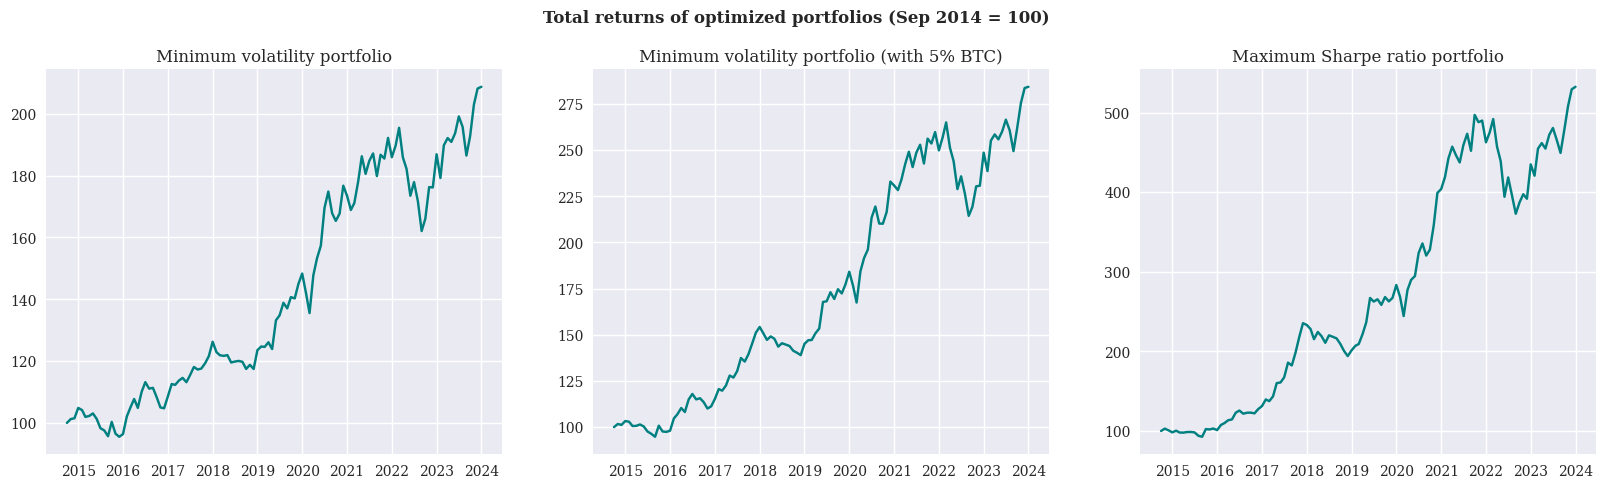

In [127]:
#Illustrate the historic development for three "optimal" portfolios in a line chart
corr_df['Min volatility ptf'] = min_vol_w['S&P 500']*corr_df['S&P 500'] + min_vol_w['Gold']*corr_df['Gold'] + min_vol_w['Bitcoin']*corr_df['Bitcoin']
corr_df['Max Sharpe ptf'] = max_SR_w['S&P 500']*corr_df['S&P 500'] + max_SR_w['Gold']*corr_df['Gold'] + max_SR_w['Bitcoin']*corr_df['Bitcoin']
corr_df['Min vola w. BTC ptf'] = min_volBTC_w['S&P 500']*corr_df['S&P 500'] + min_volBTC_w['Gold']*corr_df['Gold'] + min_volBTC_w['Bitcoin']*corr_df['Bitcoin']

corr_df['Min vola ptf index'] = 100.0
corr_df['Max Sharpe ptf index'] = 100.0
corr_df['Min vola w. BTC ptf index'] = 100.0

for i in range(len(corr_df)-1):
    corr_df['Min vola ptf index'][i+1] = corr_df['Min vola ptf index'][i] * (1 + corr_df['Min volatility ptf'][i+1])
    corr_df['Max Sharpe ptf index'][i+1] = corr_df['Max Sharpe ptf index'][i] * (1 + corr_df['Max Sharpe ptf'][i+1])
    corr_df['Min vola w. BTC ptf index'][i+1] = corr_df['Min vola w. BTC ptf index'][i] * (1 + corr_df['Min vola w. BTC ptf'][i+1])

    
fig, ax = plt.subplots(1,3, figsize=(20,5))
plt.suptitle('Total returns of optimized portfolios (Sep 2014 = 100)',fontweight='bold',y=1.0)

ax[0].plot(corr_df.index, corr_df['Min vola ptf index'],color='teal')
ax[0].set_title('Minimum volatility portfolio')

ax[1].plot(corr_df.index, corr_df['Min vola w. BTC ptf index'],color='teal')
ax[1].set_title('Minimum volatility portfolio (with 5% BTC)')

ax[2].plot(corr_df.index, corr_df['Max Sharpe ptf index'],color='teal')
ax[2].set_title('Maximum Sharpe ratio portfolio')

plt.show()

The minimum volatility portfolio would have almost doubled in value since 2014 (+63%). Adding a fixed 5% allocation to Bitcoin would have increased performance to 120%. The value of the maximum Sharpe ratio portfolio would have more than quadrupled over the period (+440%).

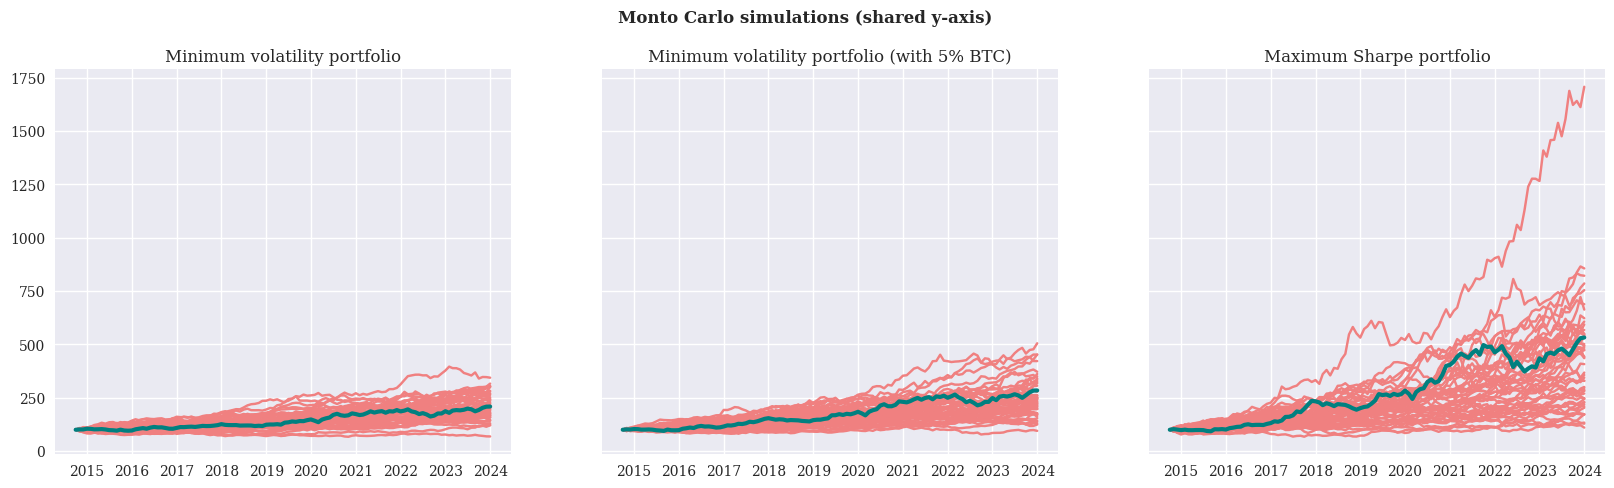

In [128]:
#Add MC simulation based on normal distribution for both portfolios (just 50 runs each for illustration)
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
plt.suptitle('Monto Carlo simulations (shared y-axis)',fontweight='bold',y=1.0)

ax[0].set_title('Minimum volatility portfolio')

ax[1].set_title('Minimum volatility portfolio (with 5% BTC)')

ax[2].set_title('Maximum Sharpe portfolio')


np.random.seed(1)

for i in range(50):

    s = np.random.normal((1+min_vol_ptf[0])**(1/12)-1, min_vol_ptf[1] / (12**0.5),112)

    corr_df['random'] = s
    corr_df['random index'] = 100.0

    for j in range(len(corr_df)-1):
        corr_df['random index'][j+1] = corr_df['random index'][j] * (1 + corr_df['random'][j+1])

    ax[0].plot(corr_df.index, corr_df['random index'],color='lightcoral')

    
for i in range(50):

    s = np.random.normal((1+min_volBTC_ptf[0])**(1/12)-1, min_volBTC_ptf[1] / (12**0.5),112)

    corr_df['random'] = s
    corr_df['random index'] = 100.0

    for j in range(len(corr_df)-1):
        corr_df['random index'][j+1] = corr_df['random index'][j] * (1 + corr_df['random'][j+1])

    ax[1].plot(corr_df.index, corr_df['random index'],color='lightcoral')  


for i in range(50):

    s = np.random.normal((1+max_SR_ptf[0])**(1/12)-1, max_SR_ptf[1] / (12**0.5),112)

    corr_df['random'] = s
    corr_df['random index'] = 100.0

    for j in range(len(corr_df)-1):
        corr_df['random index'][j+1] = corr_df['random index'][j] * (1 + corr_df['random'][j+1])

    ax[2].plot(corr_df.index, corr_df['random index'],color='lightcoral') 

    
ax[0].plot(corr_df.index, corr_df['Min vola ptf index'],color='teal',linewidth=3)
ax[1].plot(corr_df.index, corr_df['Min vola w. BTC ptf index'],color='teal',linewidth=3)
ax[2].plot(corr_df.index, corr_df['Max Sharpe ptf index'],color='teal',linewidth=3)

plt.show()

To illustrate the uncertainty of outcomes, figure above adds a simple Monte Carlo simulation of returns around the historically realized portfolio returns (with 50 runs for each portfolio). This is assuming monthly returns to be normally distributed, which admittedly is a stretch based on our prior analysis. Still, it helps illustrate the impact that a meaningful inclusion of Bitcoin in a portfolio has on risk. The "cone" of possible outcomes for the maximum Sharpe ratio portfolio (with its 18% Bitcoin allocation) is pretty wide (ranging roughly from +100% to +1200% over the period).

Scenarios for the "middle ground" portfolio, minimizing volatility under a 5% Bitcoin allocation constraint, are reasonably close to the minimum volatility portfolio (ranging roughly from 0% to +200%), corroborating our view that the risk profile is not materially changed by this small Bitcoin allocation.

## Summary and Main Findings:

**Q1) How does the performance of Bitcoin (i.e. risk and returns) compare to the S&P 500 and gold?**

Bitcoin outperforms both S&P 500 and Gold by a significant margin. This outperformance came at the expense of significantly higher risk (across a range of measures like volatility, Value-at-Risk, drawdown or daily trading range). Still, risk adjusted returns of bitcoin (sharpe ratio .83) exceeded those of gold (.43) and equities (.65).

**Q2)  How does the inclusion of Bitcoin change a portfolio's characteristics and can it help improve a portfolio's performance?**

Bitcoin inclusion into our porfolio will increase both the risk and returns significantly. Bitcoin doesn't offers any diversification advantages as we found it to be positively correlated (correlation coeff. of 0.33) with equities thus only increasing returns at the expense of larger risk.

**Q3) Could Bitcoin be used as a hedge against inflation?**

No, there has been no consistent relationship between monthly changes in the general US consumer price level and the price of Bitcoin. During high inflation period bitcoin has performed at its lowest since becoming mainstream which can be seen in the box plot in earlier section. Though, one has to be careful as the low performance can't only attributed to rising interest rate for Bitcoin as there can be a case made that this low performance is due to malpractises in the crypto industry which has been highlighted in the news lately.



## Recommendations:

**In the light of our fund's goal to minimize risk: What is the minimum volatility portfolio, consisting of these three asset classes? And for comparison: Which portfolio would maximize risk-adjusted returns?**

Historically, the portfolio minimizing volatility consisted of 42% US equities, 58% gold and no Bitcoin. This portfolio achieved a volatility of 10.64% p.a. since 2014 and a Sharpe ratio of close to 0.71. The maximum Sharpe ratio of 0.97 would have been achieved with an allocation of 45% to US equities, 40% to gold and 15% to Bitcoin. This portfolio's volatility was 16.96% p.a.

Given the very high historic volatility of Bitcoin and its limited diversification value vs. equities, there is no place for Bitcoin, when the goal is to strictly minimize the fund's volatility.But to acknowledge the superior returns and high Sharpe ratio that Bitcoin has shown so far, we still recommend to consider a small fixed allocation of 5% to Bitcoin, alongside 35% in US stocks and 60% in gold. Since 2014 such an allocation would have increased volatility relatively little compared to the minimum volatility portfolio (from 10.64% to 11.84%), while significantly improving returns (from 7.55% to 10.26%) and the Sharpe ratio (from .71 to 0.87).  